# Load Data

In [ ]:
import pandas as pd

# Baca file hasil scraping
df = pd.read_csv("/content/Scrapping komen tiktok - dataset.csv", sep=',', quotechar='"', engine='python', on_bad_lines='skip')

# Cek struktur data
print(df.shape)
print(df[['text']].head())

(36022, 11)
                        text
0  hey heyy look at me✋️✋️✋️
1             ilang arah yaa
2         day 1 hilang arah😊
3             👁️: sori gugup
4   lgian nantang bgt anj😭😭😭


# Pra-processing

In [ ]:
# cek data duplikat
print(df.duplicated(subset=['text']).sum())

4426


In [ ]:
# cek data kosong
print(df.isna().sum())

text                   440
diggCount               13
replyCommentTotal       13
createTimeISO           22
uniqueId                22
videoWebUrl             22
uid                     22
cid                     22
Label                    0
Unnamed: 9           36018
Unnamed: 10          36020
dtype: int64


In [ ]:
# hapus data duplikat dan komentar kosong
df = df.drop_duplicates(subset=['text'])
df = df.dropna(subset=['text'])

In [ ]:
# Hitung Panjang Komentar
df['char_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].astype(str).apply(lambda x: len(x.split()))

print(df[['char_len', 'word_count']].describe())

           char_len    word_count
count  31595.000000  31595.000000
mean      43.487640      7.493433
std       59.135048      9.874857
min        1.000000      1.000000
25%       19.000000      3.000000
50%       31.000000      5.000000
75%       50.000000      9.000000
max     2177.000000    765.000000


In [ ]:
import re
import string

# Case Folding + Text Cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)        # hapus URL
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # hapus mention
    text = re.sub(r'#\S+', '', text)           # hapus hashtag
    text = re.sub(r'[^a-z\s]', '', text)       # hapus non-huruf
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].astype(str).apply(clean_text)  # timpa langsung kolom 'text' biar bersih

In [ ]:
# Remove Stopward
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('indonesian'))

df['no_stopword'] = df['text'].apply(
    lambda x: ' '.join([word for word in x.split() if word not in stop_words])
)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Tokenization
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

df['tokens_nltk'] = df['no_stopword'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Balancing Data

In [ ]:
# BALANCING DATA (UNDERSAMPLING + OVERSAMPLING)

from sklearn.utils import resample

df_majority = df[df['Label'] == 0]
df_minority = df[df['Label'] == 1]

print("Sebelum balancing:")
print(df['Label'].value_counts())

# 1. Undersampling ringan kelas 0 → turunkan ke 15000
df_majority_under = resample(df_majority, replace=False, n_samples=15000, random_state=42)

# 2. Oversampling ringan kelas 1 → naikkan ke 6000
df_minority_over  = resample(df_minority, replace=True, n_samples=6000, random_state=42)

# Gabungkan
df_balanced = pd.concat([df_majority_under, df_minority_over]).sample(frac=1, random_state=42)
df_balanced = df_balanced.reset_index(drop=True)

print("\nSetelah balancing:")
print(df_balanced['Label'].value_counts())

Sebelum balancing:
Label
0    28612
1     2983
Name: count, dtype: int64

Setelah balancing:
Label
0    15000
1     6000
Name: count, dtype: int64


# Desain dan Implementasi Awal Model

### **Inisiasi Model LSTM**

Model LSTM diinisialisasi untuk mendeteksi komentar *cyberbullying* berdasarkan urutan kata. Model diawali dengan *embedding layer* berdimensi (100,100). Selanjutnya digunakan satu *LSTM layer* berukuran 128 unit, diikuti *dropout layer* dengan nilai 0,2 untuk mencegah *overfitting*. Hasil keluaran diteruskan ke *dense layer* dengan aktivasi sigmoid untuk klasifikasi biner. Model menggunakan *optimizer* yang di hyperparameter dengan *learning rate* 0,001 dan *loss function* binary cross-entropy.


In [ ]:
# IMPLEMENTASI AWAL MODEL CNN-LSTM

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# reset index supaya resampling tidak bikin index duplikat / aneh
df_balanced = df_balanced.reset_index(drop=True)

# Definisikan variabel input & label dari data yang sudah dibalance
texts = df_balanced['no_stopword'].astype(str).tolist()
labels = df_balanced['Label'].astype(int).tolist()

# 1. Tokenisasi teks -> ubah kata jadi angka
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# 2. Padding -> samakan panjang setiap urutan (biar bisa masuk ke CNN-LSTM)
maxlen = 300  # panjang maksimal per teks
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = np.array(labels)

# 3. Split data jadi train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vocab_size = len(tokenizer.word_index) + 1

print("\nJumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])
print("Panjang sequence:", X_train.shape[1])
print("Jumlah kata unik:", len(tokenizer.word_index))

print("\nDistribusi Label (sebelum split):")
print(pd.Series(y).value_counts())

print("\nDistribusi Label (train):")
print(pd.Series(y_train).value_counts())

print("\nDistribusi Label (test):")
print(pd.Series(y_test).value_counts())


Jumlah data latih: 16800
Jumlah data uji: 4200
Panjang sequence: 300
Jumlah kata unik: 17934

Distribusi Label (sebelum split):
0    15000
1     6000
Name: count, dtype: int64

Distribusi Label (train):
0    12000
1     4800
Name: count, dtype: int64

Distribusi Label (test):
0    3000
1    1200
Name: count, dtype: int64


In [ ]:
# INISIALISASI MODEL CNN-BiLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense

# Parameter dasar
vocab_size = len(tokenizer.word_index) + 1   # jumlah kata unik dari tokenizer
embedding_dim = 100                          # dimensi embedding
max_len = 300                                # panjang maksimal sequence

# Bangun model CNN-BiLSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_len),

    # CNN untuk ekstraksi fitur lokal
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Bidirectional LSTM untuk menangkap konteks dua arah
    Bidirectional(LSTM(64, return_sequences=True)),
    GlobalMaxPooling1D(),

    # Dense layer
    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

# Build agar summary lengkap
model.build(input_shape=(None, max_len))

# Tampilkan arsitektur
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 300, 100)       │     1,793,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 296, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 148, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 148, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,964,765 (7.49 MB)

 Trainable params: 1,964,765 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

# Training dan Tuning

## Import library dan setup dasar

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import itertools
import os

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

os.makedirs("models", exist_ok=True)

## Build Model LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense

def build_lstm_model(vocab_size, max_len, optimizer="adam"):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=100,
                  input_length=max_len),

        # 1️⃣ Convolution untuk ekstraksi fitur n-gram
        Conv1D(filters=128, kernel_size=5, activation="relu"),
        MaxPooling1D(pool_size=2),

        # 2️⃣ Bidirectional LSTM untuk konteks depan–belakang
        Bidirectional(LSTM(64, return_sequences=True)),
        GlobalMaxPooling1D(),

        # 3️⃣ Dense layer
        Dense(64, activation="relu"),
        Dropout(0.3),

        Dense(1, activation="sigmoid")
    ])

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )

    return model

## Hyperparameter Grid (Optimizer + Epochs)

In [ ]:
param_optimizer = ["adam", "rmsprop"]
param_epochs = [5, 10]

# Buat kombinasi
grid_combinations = list(itertools.product(param_optimizer, param_epochs))
print("Total combinations:", len(grid_combinations))
grid_combinations

Total combinations: 4


[('adam', 5), ('adam', 10), ('rmsprop', 5), ('rmsprop', 10)]

In [ ]:
import time

best_model = None
best_history = None
best_val_loss = np.inf

start_time = time.time()

for (opt, ep) in grid_combinations:
    print(f"\n=== Training {opt}, epochs={ep} ===")

    tf.keras.backend.clear_session()

    model_i = build_lstm_model(vocab_size, 300, optimizer=opt)
    history = model_i.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=ep,
        batch_size=64,
        verbose=2
    )

    min_val = min(history.history['val_loss'])
    print("min val loss =", min_val)

    if min_val < best_val_loss:
        best_val_loss = min_val
        best_model = model_i
        best_history = history  # <--- Added this line to store the best history
        model_i.save("models/best_lstm_final.h5")
        print(" ✓ Improved! Model saved.")


=== Training adam, epochs=5 ===
Epoch 1/5
237/237 - 12s - 52ms/step - accuracy: 0.7544 - auc: 0.6957 - loss: 0.5335 - val_accuracy: 0.7863 - val_auc: 0.8013 - val_loss: 0.4713
Epoch 2/5
237/237 - 5s - 19ms/step - accuracy: 0.8838 - auc: 0.9277 - loss: 0.2935 - val_accuracy: 0.8250 - val_auc: 0.8675 - val_loss: 0.4164
Epoch 3/5
237/237 - 4s - 19ms/step - accuracy: 0.9468 - auc: 0.9817 - loss: 0.1478 - val_accuracy: 0.8423 - val_auc: 0.8745 - val_loss: 0.4617
Epoch 4/5
237/237 - 5s - 21ms/step - accuracy: 0.9657 - auc: 0.9919 - loss: 0.0984 - val_accuracy: 0.8554 - val_auc: 0.8685 - val_loss: 0.5726
Epoch 5/5
237/237 - 4s - 19ms/step - accuracy: 0.9711 - auc: 0.9942 - loss: 0.0808 - val_accuracy: 0.8560 - val_auc: 0.8744 - val_loss: 0.5793


min val loss = 0.41640704870224
 ✓ Improved! Model saved.

=== Training adam, epochs=10 ===
Epoch 1/10
237/237 - 8s - 35ms/step - accuracy: 0.7523 - auc: 0.6902 - loss: 0.5371 - val_accuracy: 0.7768 - val_auc: 0.7985 - val_loss: 0.4742
Epoch 2/10
237/237 - 4s - 19ms/step - accuracy: 0.8805 - auc: 0.9228 - loss: 0.3018 - val_accuracy: 0.8208 - val_auc: 0.8562 - val_loss: 0.4380
Epoch 3/10
237/237 - 5s - 21ms/step - accuracy: 0.9425 - auc: 0.9804 - loss: 0.1538 - val_accuracy: 0.8417 - val_auc: 0.8697 - val_loss: 0.4925
Epoch 4/10
237/237 - 4s - 19ms/step - accuracy: 0.9632 - auc: 0.9914 - loss: 0.1013 - val_accuracy: 0.8482 - val_auc: 0.8678 - val_loss: 0.5794
Epoch 5/10
237/237 - 5s - 19ms/step - accuracy: 0.9726 - auc: 0.9947 - loss: 0.0771 - val_accuracy: 0.8536 - val_auc: 0.8705 - val_loss: 0.6401
Epoch 6/10
237/237 - 5s - 20ms/step - accuracy: 0.9753 - auc: 0.9961 - loss: 0.0682 - val_accuracy: 0.8476 - val_auc: 0.8644 - val_loss: 0.7101
Epoch 7/10
237/237 - 4s - 19ms/step - accura

## Evaluasi Model Terbaik

In [ ]:
y_prob = best_model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Accuracy: 0.8628571428571429
ROC AUC: 0.8872181944444444

Classification report:
               precision    recall  f1-score   support

           0     0.9037    0.9043    0.9040      3000
           1     0.7604    0.7592    0.7598      1200

    accuracy                         0.8629      4200
   macro avg     0.8321    0.8317    0.8319      4200
weighted avg     0.8628    0.8629    0.8628      4200

[[2713  287]
 [ 289  911]]


## Plot ROC Curve

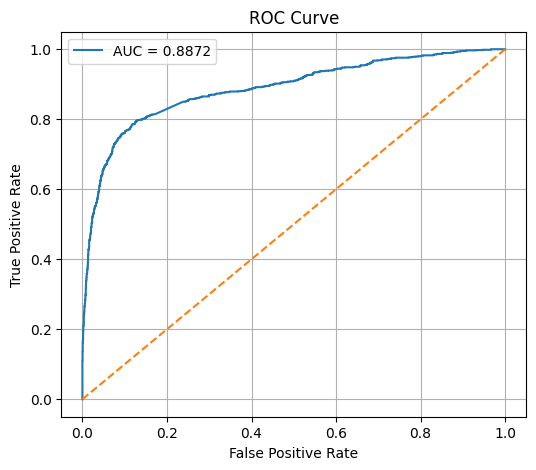

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

## Plot History dari Model Terbaik

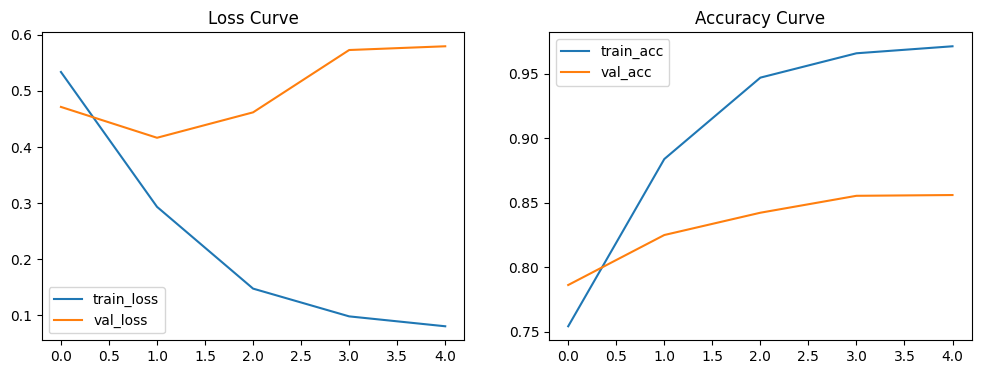

In [ ]:
h = best_history.history

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(h['loss'], label='train_loss')
plt.plot(h['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(h['accuracy'], label='train_acc')
plt.plot(h['val_accuracy'], label='val_acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()